# 프로젝트 - Movielens 영화 SBR

# 데이터
- Movielens 1M Dataset
- 약 3,900편의 영화에 대한 1,000,209개의 익명 등급이 포함
- 데이터 요약 : https://files.grouplens.org/datasets/movielens/ml-1m-README.txt

# 1. 데이터의 전처리
# 1-1. Data Load

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 추천시스템을 구축하기 위해 **유저수** 와 **아이템 수** 를 확인해봄.
- 유저의 수는 약 6천개, 아이템의 수는 약 3천개
- 같은 유저가 여러 개의 세션을 만든거일 수도 있기 때문에 유저의 수가 약 6천명은 아님

# 1-2. Session Length
- 각 세션이 대략 몇 개의 평점 데이터를 갖는지 확인

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- **user_length** : 같은 UserId를 공유하는 데이터 row의 개수를 의미, 한 유저ID가 몇 개의 영화에 평점 데이터를 남겼는지
- **UserId** : 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자입니다. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 UserId 기준으로 모아서 분류해낼 수는 있음
- **session_length** : 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미

In [5]:
user_length.median(), user_length.mean()  # 중앙값 96개, 평균값 약 165개

(96.0, 165.5975165562914)

In [6]:
user_length.min(), user_length.max() # 최소 20개, 최대 2314개

(20, 2314)

In [7]:
user_length.quantile(0.999) # 99.9%의 유저들은 1343개 이하의 rating을 가짐

1343.181000000005

In [8]:
from scipy.stats import mode
mode(user_length)

ModeResult(mode=array([21]), count=array([91]))

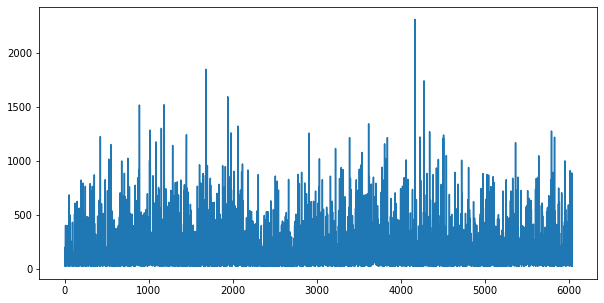

In [9]:
# user_length 기준 그래프
plt.figure(figsize=(10, 5))
plt.plot(user_length)
plt.show()

In [10]:
# 평점 데이터가 많은 순으로 정렬
mv_count = data.groupby('ItemId')['UserId'].count()
mv_count.sort_values(ascending=False).head(10)

ItemId
2858    3428
260     2991
1196    2990
1210    2883
480     2672
2028    2653
589     2649
2571    2590
1270    2583
593     2578
Name: UserId, dtype: int64

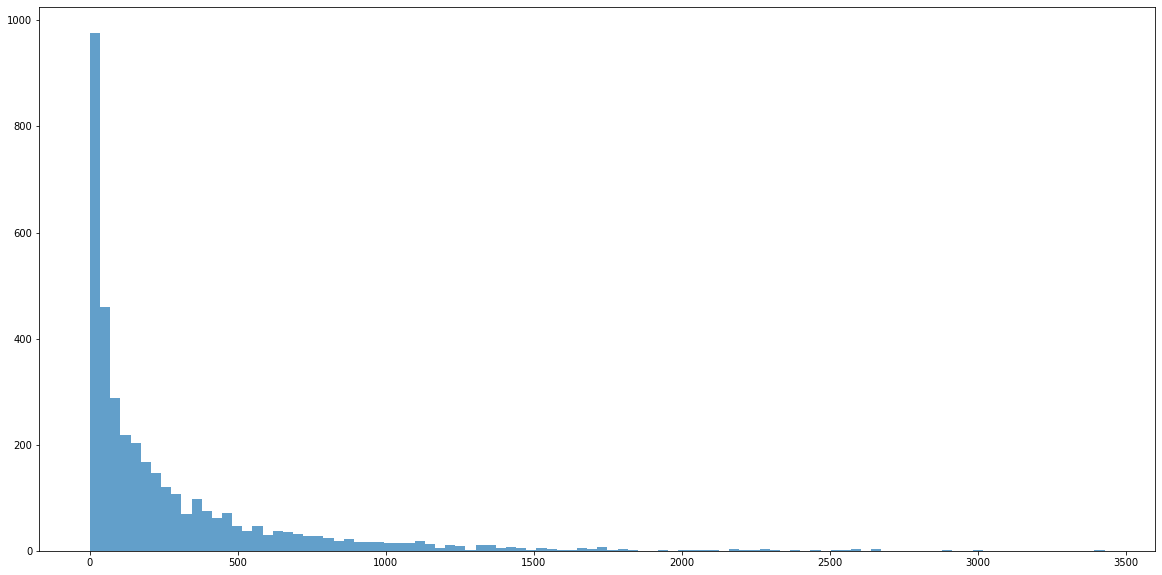

In [11]:
plt.figure(figsize=(20,10))
plt.hist(mv_count, bins=100, density=False, alpha=0.7, histtype='stepfilled')
plt.show()

- 평점이 100개이내인 영화가 대부분
- 개수 자체에 선호도와 연관이 크게 없어 보임

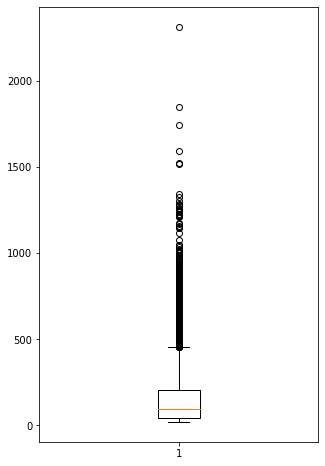

In [12]:
# user_length 기준 상자수염 그래프
plt.figure(figsize=(5,8))
plt.boxplot(user_length)
plt.show()

- 세션 길이 2000이 넘는 것은 boxplot 상의 이상치들 중에서도 매우 멀리 떨어져 있음

In [13]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

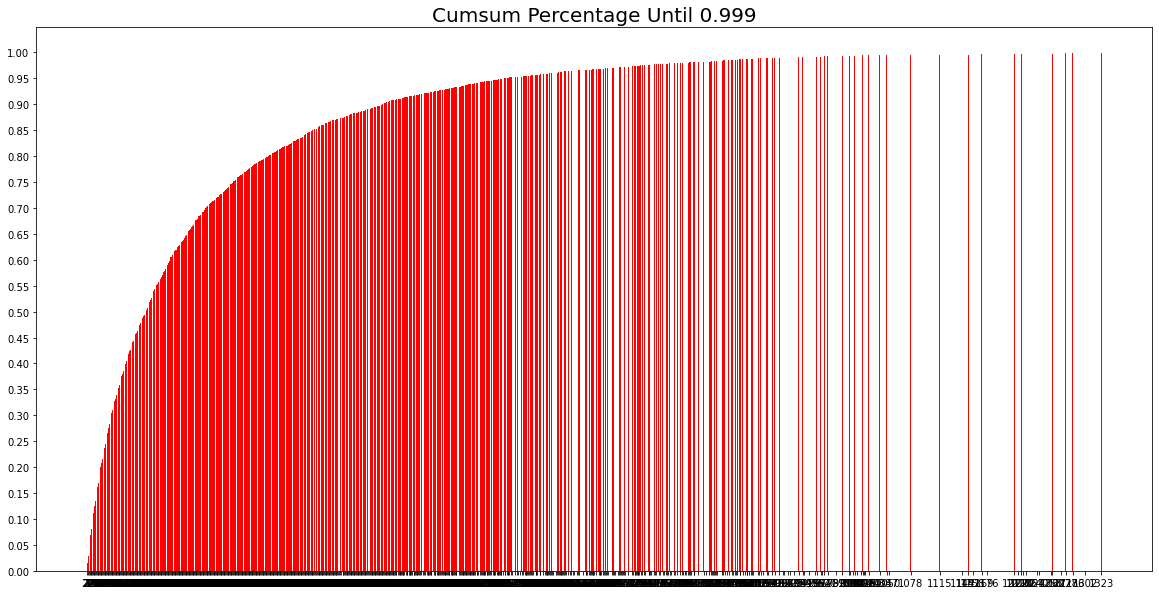

In [14]:
# user_length 기준 하위 99.9%까지의 분포 누적합을 시각화
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

데이터를 보니 99.9%의 User가 남긴 평점 데이터는
> 1. 20부터 약 1400까지 그 스펙트럼이 매우 넓음
> 2. 그 값들이 매우 다양함

- userId,time이 같고 itemId만 다른 경우가 있는데 이런 경우는 말이 안되기 때문에 제거

# 1-3. Session Time

- 추천 시스템에서 다루는 시간 관련 데이터는 접속하는 데이터 생성 날짜, 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등 있음

In [15]:
import datetime

In [16]:
# 우선 Time 컬럼이 보기가 힘드니 Date 로 바꿔서 보겠습니다

dt = datetime.datetime.strptime('1970-01-01', '%Y-%m-%d')
tmp = data['Time']
datatime = []
for i in tmp:
    date = dt + datetime.timedelta(seconds= i)
    tmp = date.strftime('%Y-%m-%d')
    datatime.append(tmp)

data['Date'] = datatime

In [17]:
data

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [18]:
oldest, latest = data['Date'].min(), data['Date'].max()
print(oldest) 
print(latest)

2000-04-25
2003-02-28


- 약 3년간의 데이터
- 연도별로 데이터를 나눔

In [19]:
yr2000 = data[data['Date'].str.contains('2000')]
yr2001 = data[data['Date'].str.contains('2001')]
yr2002 = data[data['Date'].str.contains('2002')]
yr2003 = data[data['Date'].str.contains('2003')]

In [20]:
print(len(yr2000))
print(len(yr2001))
print(len(yr2002))
print(len(yr2003))

904757
68058
24046
3348


#### 시간 흐름에 따른 영화 선호 함 보기
#### 전체 기간에서 평점이 많이 남겨진 영화

In [21]:
#영화 평점 분포 확인

mv_rate = data.groupby('Rating')['ItemId'].count()
mv_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: ItemId, dtype: int64

- 1점인 영화는 선호하는 영화에서 거리가 머니 나중에 제거함

In [22]:
# 2000년도에 가장 인기있는 영화는?
mv_count0 = yr2000.groupby('ItemId')['UserId'].count()
mv_count0.sort_values(ascending=False).head(10)

ItemId
2858    3291
1196    2846
260     2834
1210    2772
480     2559
589     2547
2028    2538
1270    2448
2571    2446
1580    2433
Name: UserId, dtype: int64

In [23]:
# 2001년도에 가장 인기있는 영화는?
mv_count1 = yr2001.groupby('ItemId')['UserId'].count()
mv_count1.sort_values(ascending=False).head(10)

ItemId
3897    266
3578    241
3751    213
3948    211
3317    199
3911    181
3408    179
3863    157
3793    151
3753    151
Name: UserId, dtype: int64

In [24]:
# 2002년도에 가장 인기있는 영화는?
mv_count2 = yr2002.groupby('ItemId')['UserId'].count()
mv_count2.sort_values(ascending=False).head(10)

ItemId
3897    68
3911    67
3949    57
3317    57
1393    56
1265    52
3948    49
3578    48
2628    48
2959    46
Name: UserId, dtype: int64

In [25]:
# 2003년도에 가장 인기있는 영화는?
mv_count3 = yr2003.groupby('ItemId')['UserId'].count()
mv_count3.sort_values(ascending=False).head(10)

ItemId
2011    14
2959    12
3948    12
2502    12
2012    11
3911    11
1095    11
2028    10
750     10
2300     9
Name: UserId, dtype: int64

- 해가 지날 수록 세션 수(유저 수)가 점점 줄어들고 있음
- 매년 평점이 많이 남았던 영화가 달라졌지만 3897번 영화처럼 꾸준히 많은 평점을 받은 영화도 있음

#### 가장 높은 평점을 가진 영화는 무엇일까
#### 평점 순으로 줄세워보기

In [26]:
#영화 평점 분포 확인

mv_rate = data.groupby('Rating')['ItemId'].count()
mv_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: ItemId, dtype: int64

In [27]:
yr2000_rate = yr2000.groupby('Rating')['ItemId'].count()
yr2000_rate

Rating
1     51027
2     96069
3    234296
4    314446
5    208919
Name: ItemId, dtype: int64

In [28]:
yr2001_rate = yr2001.groupby('Rating')['ItemId'].count()
yr2001_rate

Rating
1     3539
2     7986
3    19150
4    24839
5    12544
Name: ItemId, dtype: int64

In [29]:
yr2002_rate = yr2002.groupby('Rating')['ItemId'].count()
yr2002_rate

Rating
1    1356
2    3113
3    6898
4    8500
5    4179
Name: ItemId, dtype: int64

In [30]:
yr2003_rate = yr2003.groupby('Rating')['ItemId'].count()
yr2003_rate

Rating
1     252
2     389
3     853
4    1186
5     668
Name: ItemId, dtype: int64

In [31]:
orginal_data_size = len(data)
orginal_data_size

1000209

In [32]:
# 전체 데이터셋에서 Rating 3점 이상만 남김

data = data[data['Rating']>=3]

filtered_data_size = len(data)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [33]:
data[data['Rating']==2]

,UserId,ItemId,Rating,Time,Date


In [34]:
data[data['Rating']==1]

,UserId,ItemId,Rating,Time,Date


In [35]:
data[data['Rating']>=3]

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


- Rating 3점 미만만 잘 제거된 것을 확인함

# 1-4. Data Cleansing

In [36]:
# 너무 긴 세션을 가지고 있는 UserID를 제거
# 남긴 평점이 적다고 해서 선호하는 영화가 아닌 거는 아님
# 적은 평점을 가진 영화가 대부분이기도 하기때문에 
# 다른 cleansing 처리는 하지 않음

def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len < longest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_recursive(data: pd.DataFrame, longest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [37]:
data = cleanse_recursive(data, 2314)

In [38]:
# 한 유저ID가 몇 개의 영화에 평점 데이터를 남겼는지
user_length = data.groupby('UserId').size()

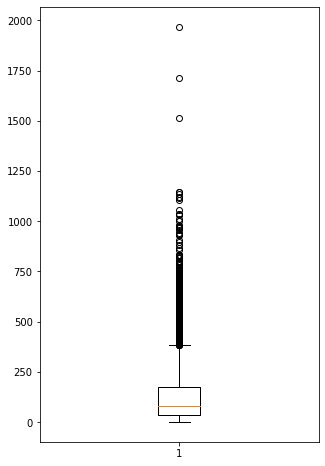

In [39]:
plt.figure(figsize=(5,8))
plt.boxplot(user_length)
plt.show()

- UserID가 잘 제거되었음

# 1-5. Train / Valid / Test split
- 영화는 최근 본 영화가 마음에 들을수록 그와 비슷한 영화를 보게 될 확률이 높아짐
> Train set: 2000년 4월 ~ 2001년 4월 까지          
> Valid set : 2001년 5월 ~ 2001년 12월 까지            
> Test set : 2002년 1월 ~ 2003년 2월까지

In [40]:
data['Date'].max()

'2003-02-28'

In [41]:
data.groupby('UserId')['Date'].max()

UserId
1       2001-01-06
2       2000-12-31
3       2000-12-31
4       2000-12-31
5       2000-12-31
           ...    
6036    2000-04-26
6037    2000-04-27
6038    2000-04-26
6039    2000-04-26
6040    2001-08-20
Name: Date, Length: 6039, dtype: object

In [42]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

def split_by_month(data: pd.DataFrame, n_months: int):
    final_time = pd.to_datetime(data['Date'].max())
    #print(final_time)
    session_last_time = data.groupby('UserId')['Date'].max()
    tmp = final_time - relativedelta(months = n_months)   # 맨 끝 날짜에서 n개월을 뺍니다
    tmpdate = tmp.strftime('%Y-%m-%d') # string 타입으로 변환
    #print(tmp)
    session_in_train = session_last_time[session_last_time < tmpdate].index
    session_in_test = session_last_time[session_last_time >= tmpdate].index
    
    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [43]:
train, test = split_by_month(data, n_months=14)
train, valid = split_by_month(train, n_months=8)

In [44]:
#train = pd.concat([yr2000,yr2001], ignore_index=True)
train

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
999798,6039,1148,4,956758002,2000-04-26
999764,6039,912,4,956758029,2000-04-26
999771,6039,922,5,956758029,2000-04-26
999815,6039,1204,5,956758029,2000-04-26


In [45]:
train['Date'].max()

'2001-04-25'

In [46]:
valid

,UserId,ItemId,Rating,Time,Date
2469,19,2527,3,978146700,2000-12-30
2298,19,593,5,978146713,2000-12-30
2432,19,527,3,978146727,2000-12-30
2457,19,1210,4,978146747,2000-12-30
2497,19,2115,3,978146747,2000-12-30
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [47]:
test

,UserId,ItemId,Rating,Time,Date
2522,20,2028,4,978143106,2000-12-30
2516,20,1617,5,978143181,2000-12-30
2515,20,47,5,978143306,2000-12-30
2514,20,3578,5,978143344,2000-12-30
2501,20,3863,3,978143355,2000-12-30
...,...,...,...,...,...
994100,6002,2013,4,1014524679,2002-02-24
993890,6002,2520,4,1014524680,2002-02-24
994045,6002,1387,5,1014524720,2002-02-24
993900,6002,1927,4,1014524758,2002-02-24


In [48]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Date"].min()}\n'
          f'\t Last Time : {data["Date"].max()}\n')

In [49]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 590449
	 Users: 5150
	 Items: 3556
	 First Time : 2000-04-25
	 Last Time : 2001-04-25

* valid Set Stats Info
	 Events: 63883
	 Users: 300
	 Items: 3076
	 First Time : 2000-04-25
	 Last Time : 2001-12-26

* test Set Stats Info
	 Events: 182046
	 Users: 589
	 Items: 3381
	 First Time : 2000-04-27
	 Last Time : 2003-02-28



In [50]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [51]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# GRU4REC 소개
> 2016년 ICLR에 공개된 SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS      
> Session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표       

#### 모델 구조          

- 여러 RNN 계열의 모델(e.g. LSTM)이 있겠지만 저자가 실험해 본 결과 GRU의 성능이 제일 좋았다고 한다.
- 이번에서 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용한다.     
- 대신 추천 데이터의 특징 몇 가지를 살려 모델링을 한다.          

1. Session-Parallel Mini-Batches
- Session의 길이는 매우 짧은 것들이 대부분이다. 그러나 매우 긴 것도 있다.
- 이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들은 기다려야한다.
- 논문의 저자는 대신 Session-parallel Mini-Batches를 제안한다. 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산한다는 것이다.
          
![](https://d3s0tskafalll9.cloudfront.net/media/images/input1.max-800x600.png)
![](https://d3s0tskafalll9.cloudfront.net/media/images/input2.max-800x600.png)  

2. SAMPLING ON THE OUTPUT
-  Negative Sampling와 같은 개념이다.
-  Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling한다. 이번에는 구현하지 않았다.


3. Ranking Loss
-  Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수 있다.
-  그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있다.
-  추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했다.
- 이번에는 Classification Task를 보고 Cross-Entropy Loss를 사용했다.

# 2. 미니 배치의 구성
- Session-Parallel Mini Batch를 구현
- 이 프로젝트에서는 Session이 아닌 UserID 기반
- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듬

# 2.1 SessionDataset

In [52]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [53]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [54]:
train_dataset.click_offsets

array([     0,     53,    169, ..., 590312, 590330, 590449], dtype=int32)

In [55]:
train_dataset.session_idx

array([   0,    1,    2, ..., 5147, 5148, 5149])

# 2-2. Session DataLoader
- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듬

In [56]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [57]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [58]:
iter_ex = iter(train_data_loader)

In [59]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# 3. 모델 구성

1. Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋음       
> 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용            
> 모델 성능에 대한 지표 : precision, recall

2. 추천에서는 몇 번째로 맞추느냐도 중요      
> 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용         

3. 이번 자료에서는 MRR과 Recall@k를 사용
> MRR은 정답 아이템이 나온 순번의 역수 값                       
> 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것           

In [60]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### GRU4REC 모델 구조를 구현

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [62]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [63]:
class Args:
    def __init__(self, train, valid, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.valid = valid
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)

In [64]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


#  4. 모델 학습

In [65]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.valid, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [69]:
train_model(model, args)

Evaluation:  21%|██▏       | 53/248 [00:56<03:29,  1.07s/it]


	 - Recall@20 epoch 1: 0.144973
	 - MRR@20    epoch 1: 0.035413



Evaluation:  21%|██▏       | 53/248 [00:52<03:12,  1.01it/s]


	 - Recall@20 epoch 2: 0.269163
	 - MRR@20    epoch 2: 0.073633



Evaluation:  21%|██▏       | 53/248 [00:50<03:06,  1.05it/s]


	 - Recall@20 epoch 3: 0.313974
	 - MRR@20    epoch 3: 0.088369



Evaluation:  21%|██▏       | 53/248 [00:50<03:05,  1.05it/s]


	 - Recall@20 epoch 4: 0.333358
	 - MRR@20    epoch 4: 0.098254



Evaluation:  21%|██▏       | 53/248 [00:49<03:02,  1.07it/s]


	 - Recall@20 epoch 5: 0.347583
	 - MRR@20    epoch 5: 0.103644



Evaluation:  21%|██▏       | 53/248 [00:49<03:00,  1.08it/s]


	 - Recall@20 epoch 6: 0.355027
	 - MRR@20    epoch 6: 0.107024



Evaluation:  21%|██▏       | 53/248 [00:48<03:00,  1.08it/s]


	 - Recall@20 epoch 7: 0.358269
	 - MRR@20    epoch 7: 0.110475



Evaluation:  21%|██▏       | 53/248 [00:49<03:00,  1.08it/s]


	 - Recall@20 epoch 8: 0.363355
	 - MRR@20    epoch 8: 0.113121



Evaluation:  21%|██▏       | 53/248 [00:48<02:59,  1.09it/s]


	 - Recall@20 epoch 9: 0.366966
	 - MRR@20    epoch 9: 0.115038



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 10: 0.369030
	 - MRR@20    epoch 10: 0.117368



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 11: 0.371683
	 - MRR@20    epoch 11: 0.118686



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 12: 0.373084
	 - MRR@20    epoch 12: 0.120092



Evaluation:  21%|██▏       | 53/248 [00:48<02:59,  1.09it/s]


	 - Recall@20 epoch 13: 0.373452
	 - MRR@20    epoch 13: 0.120983



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 14: 0.373526
	 - MRR@20    epoch 14: 0.121517



Evaluation:  21%|██▏       | 53/248 [00:48<02:59,  1.09it/s]


	 - Recall@20 epoch 15: 0.374705
	 - MRR@20    epoch 15: 0.122104



Evaluation:  21%|██▏       | 53/248 [00:48<02:59,  1.09it/s]


	 - Recall@20 epoch 16: 0.375884
	 - MRR@20    epoch 16: 0.122539



Evaluation:  21%|██▏       | 53/248 [00:49<03:00,  1.08it/s]


	 - Recall@20 epoch 17: 0.377358
	 - MRR@20    epoch 17: 0.123172



Evaluation:  21%|██▏       | 53/248 [00:48<02:59,  1.09it/s]


	 - Recall@20 epoch 18: 0.377727
	 - MRR@20    epoch 18: 0.123571



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 19: 0.378390
	 - MRR@20    epoch 19: 0.124315



Evaluation:  21%|██▏       | 53/248 [00:48<02:59,  1.09it/s]


	 - Recall@20 epoch 20: 0.378538
	 - MRR@20    epoch 20: 0.124035



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 21: 0.378464
	 - MRR@20    epoch 21: 0.124822



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 22: 0.379054
	 - MRR@20    epoch 22: 0.125737



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 23: 0.378611
	 - MRR@20    epoch 23: 0.125468



Evaluation:  21%|██▏       | 53/248 [00:48<02:56,  1.10it/s]


	 - Recall@20 epoch 24: 0.378980
	 - MRR@20    epoch 24: 0.125590



Evaluation:  21%|██▏       | 53/248 [00:48<02:56,  1.10it/s]


	 - Recall@20 epoch 25: 0.377948
	 - MRR@20    epoch 25: 0.125705



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 26: 0.377801
	 - MRR@20    epoch 26: 0.125549



Evaluation:  21%|██▏       | 53/248 [00:47<02:56,  1.10it/s]


	 - Recall@20 epoch 27: 0.379275
	 - MRR@20    epoch 27: 0.126710



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.10it/s]


	 - Recall@20 epoch 28: 0.377432
	 - MRR@20    epoch 28: 0.126004



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 29: 0.377358
	 - MRR@20    epoch 29: 0.125776



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 30: 0.377137
	 - MRR@20    epoch 30: 0.126277



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 31: 0.375811
	 - MRR@20    epoch 31: 0.125555



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 32: 0.377432
	 - MRR@20    epoch 32: 0.126250



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 33: 0.376843
	 - MRR@20    epoch 33: 0.126623



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 34: 0.376474
	 - MRR@20    epoch 34: 0.126589



Evaluation:  21%|██▏       | 53/248 [00:47<02:55,  1.11it/s]


	 - Recall@20 epoch 35: 0.376327
	 - MRR@20    epoch 35: 0.126595



Evaluation:  21%|██▏       | 53/248 [00:48<02:56,  1.10it/s]


	 - Recall@20 epoch 36: 0.377137
	 - MRR@20    epoch 36: 0.126537



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 37: 0.376916
	 - MRR@20    epoch 37: 0.126188



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 38: 0.374558
	 - MRR@20    epoch 38: 0.126015



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 39: 0.375737
	 - MRR@20    epoch 39: 0.125727



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 40: 0.376327
	 - MRR@20    epoch 40: 0.126127



Evaluation:  21%|██▏       | 53/248 [00:47<02:56,  1.10it/s]


	 - Recall@20 epoch 41: 0.375074
	 - MRR@20    epoch 41: 0.125520



Evaluation:  21%|██▏       | 53/248 [00:47<02:56,  1.11it/s]


	 - Recall@20 epoch 42: 0.374116
	 - MRR@20    epoch 42: 0.125757



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 43: 0.374705
	 - MRR@20    epoch 43: 0.125500



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 44: 0.374189
	 - MRR@20    epoch 44: 0.125458



Evaluation:  21%|██▏       | 53/248 [00:47<02:56,  1.11it/s]


	 - Recall@20 epoch 45: 0.374337
	 - MRR@20    epoch 45: 0.125624



Evaluation:  21%|██▏       | 53/248 [00:47<02:56,  1.10it/s]


	 - Recall@20 epoch 46: 0.375516
	 - MRR@20    epoch 46: 0.125769



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 47: 0.375663
	 - MRR@20    epoch 47: 0.124966



Evaluation:  21%|██▏       | 53/248 [00:48<02:57,  1.10it/s]


	 - Recall@20 epoch 48: 0.373821
	 - MRR@20    epoch 48: 0.125412



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]


	 - Recall@20 epoch 49: 0.374189
	 - MRR@20    epoch 49: 0.125194



Evaluation:  21%|██▏       | 53/248 [00:48<02:58,  1.09it/s]

	 - Recall@20 epoch 50: 0.375663
	 - MRR@20    epoch 50: 0.125066



# 5. 모델 테스트

In [70]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  67%|██████▋   | 473/708 [07:42<03:49,  1.02it/s]

	 - Recall@20: 0.282101
	 - MRR@20: 0.086337



# 2번째 모델 - 하이퍼파라미터 변경

In [66]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.4, lr=0.001, epochs=30, k=20)

In [67]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [68]:
train_model(model, args)

Evaluation:  59%|█████▊    | 291/496 [02:54<02:03,  1.66it/s]


	 - Recall@20 epoch 1: 0.157216
	 - MRR@20    epoch 1: 0.036442



Evaluation:  59%|█████▊    | 291/496 [02:48<01:58,  1.72it/s]


	 - Recall@20 epoch 2: 0.249651
	 - MRR@20    epoch 2: 0.063485



Evaluation:  59%|█████▊    | 291/496 [02:50<02:00,  1.70it/s]


	 - Recall@20 epoch 3: 0.278055
	 - MRR@20    epoch 3: 0.072556



Evaluation:  59%|█████▊    | 291/496 [02:42<01:54,  1.79it/s]


	 - Recall@20 epoch 4: 0.294432
	 - MRR@20    epoch 4: 0.079525



Evaluation:  59%|█████▊    | 291/496 [02:42<01:54,  1.79it/s]


	 - Recall@20 epoch 5: 0.302486
	 - MRR@20    epoch 5: 0.083359



Evaluation:  59%|█████▊    | 291/496 [02:44<01:55,  1.77it/s]


	 - Recall@20 epoch 6: 0.310701
	 - MRR@20    epoch 6: 0.086742



Evaluation:  59%|█████▊    | 291/496 [02:38<01:51,  1.84it/s]


	 - Recall@20 epoch 7: 0.315641
	 - MRR@20    epoch 7: 0.089534



Evaluation:  59%|█████▊    | 291/496 [02:40<01:53,  1.81it/s]


	 - Recall@20 epoch 8: 0.319963
	 - MRR@20    epoch 8: 0.090952



Evaluation:  59%|█████▊    | 291/496 [02:37<01:51,  1.85it/s]


	 - Recall@20 epoch 9: 0.321735
	 - MRR@20    epoch 9: 0.092164



Evaluation:  59%|█████▊    | 291/496 [02:39<01:52,  1.83it/s]


	 - Recall@20 epoch 10: 0.324420
	 - MRR@20    epoch 10: 0.093279



Evaluation:  59%|█████▊    | 291/496 [02:41<01:53,  1.80it/s]


	 - Recall@20 epoch 11: 0.324984
	 - MRR@20    epoch 11: 0.093884



Evaluation:  59%|█████▊    | 291/496 [02:38<01:51,  1.84it/s]


	 - Recall@20 epoch 12: 0.326944
	 - MRR@20    epoch 12: 0.094924



Evaluation:  59%|█████▊    | 291/496 [02:40<01:52,  1.82it/s]


	 - Recall@20 epoch 13: 0.329494
	 - MRR@20    epoch 13: 0.095251



Evaluation:  59%|█████▊    | 291/496 [02:40<01:52,  1.82it/s]


	 - Recall@20 epoch 14: 0.329011
	 - MRR@20    epoch 14: 0.095926



Evaluation:  59%|█████▊    | 291/496 [02:41<01:53,  1.80it/s]


	 - Recall@20 epoch 15: 0.329548
	 - MRR@20    epoch 15: 0.096169



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]


	 - Recall@20 epoch 16: 0.329118
	 - MRR@20    epoch 16: 0.096509



Evaluation:  59%|█████▊    | 291/496 [02:45<01:56,  1.75it/s]


	 - Recall@20 epoch 17: 0.330407
	 - MRR@20    epoch 17: 0.096927



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]


	 - Recall@20 epoch 18: 0.332152
	 - MRR@20    epoch 18: 0.097461



Evaluation:  59%|█████▊    | 291/496 [02:45<01:56,  1.76it/s]


	 - Recall@20 epoch 19: 0.331212
	 - MRR@20    epoch 19: 0.097415



Evaluation:  59%|█████▊    | 291/496 [02:46<01:56,  1.75it/s]


	 - Recall@20 epoch 20: 0.332152
	 - MRR@20    epoch 20: 0.098281



Evaluation:  59%|█████▊    | 291/496 [02:43<01:55,  1.78it/s]


	 - Recall@20 epoch 21: 0.331508
	 - MRR@20    epoch 21: 0.098117



Evaluation:  59%|█████▊    | 291/496 [02:47<01:58,  1.74it/s]


	 - Recall@20 epoch 22: 0.330273
	 - MRR@20    epoch 22: 0.098198



Evaluation:  59%|█████▊    | 291/496 [02:45<01:56,  1.75it/s]


	 - Recall@20 epoch 23: 0.329467
	 - MRR@20    epoch 23: 0.098265



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]


	 - Recall@20 epoch 24: 0.331588
	 - MRR@20    epoch 24: 0.099336



Evaluation:  59%|█████▊    | 291/496 [02:47<01:57,  1.74it/s]


	 - Recall@20 epoch 25: 0.331105
	 - MRR@20    epoch 25: 0.099467



Evaluation:  59%|█████▊    | 291/496 [02:45<01:56,  1.76it/s]


	 - Recall@20 epoch 26: 0.331239
	 - MRR@20    epoch 26: 0.099254



Evaluation:  59%|█████▊    | 291/496 [02:44<01:56,  1.77it/s]


	 - Recall@20 epoch 27: 0.331857
	 - MRR@20    epoch 27: 0.099110



Evaluation:  59%|█████▊    | 291/496 [02:47<01:57,  1.74it/s]


	 - Recall@20 epoch 28: 0.331105
	 - MRR@20    epoch 28: 0.098576



Evaluation:  59%|█████▊    | 291/496 [02:47<01:57,  1.74it/s]


	 - Recall@20 epoch 29: 0.331266
	 - MRR@20    epoch 29: 0.099660



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]

	 - Recall@20 epoch 30: 0.332098
	 - MRR@20    epoch 30: 0.099280



In [69]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1181/1417 [11:34<02:18,  1.70it/s]

	 - Recall@20: 0.274344
	 - MRR@20: 0.080527



# 3번째 모델 - 모델 구조 (loss 종류) 변경

In [75]:
from tensorflow.keras.losses import mse

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=mse, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [76]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [77]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [78]:
train_model(model, args)

Evaluation:  59%|█████▊    | 291/496 [02:49<01:59,  1.72it/s]


	 - Recall@20 epoch 1: 0.067306
	 - MRR@20    epoch 1: 0.013468



Evaluation:  59%|█████▊    | 291/496 [02:48<01:58,  1.73it/s]


	 - Recall@20 epoch 2: 0.068675
	 - MRR@20    epoch 2: 0.013892



Evaluation:  59%|█████▊    | 291/496 [02:48<01:58,  1.72it/s]


	 - Recall@20 epoch 3: 0.069480
	 - MRR@20    epoch 3: 0.014008



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]


	 - Recall@20 epoch 4: 0.069480
	 - MRR@20    epoch 4: 0.014052



Evaluation:  59%|█████▊    | 291/496 [02:47<01:57,  1.74it/s]


	 - Recall@20 epoch 5: 0.069534
	 - MRR@20    epoch 5: 0.014056



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]


	 - Recall@20 epoch 6: 0.069400
	 - MRR@20    epoch 6: 0.014072



Evaluation:  59%|█████▊    | 291/496 [02:45<01:56,  1.75it/s]


	 - Recall@20 epoch 7: 0.069104
	 - MRR@20    epoch 7: 0.014052



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]


	 - Recall@20 epoch 8: 0.069319
	 - MRR@20    epoch 8: 0.014068



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]


	 - Recall@20 epoch 9: 0.069131
	 - MRR@20    epoch 9: 0.014072



Evaluation:  59%|█████▊    | 291/496 [02:46<01:57,  1.75it/s]

	 - Recall@20 epoch 10: 0.069104
	 - MRR@20    epoch 10: 0.014081



In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1181/1417 [11:21<02:16,  1.73it/s]

	 - Recall@20: 0.047179
	 - MRR@20: 0.009182



# 결과 및 회고

- 이번 프로젝트에서는 세션 기반의 추천 시스템을 만들어 보았다. 데이터 전처리 과정에서 평점이 3점 이하인 데이터를 제거하고, 데이터 전처리에서 시각화했을 때, 세션 길이 2000이 넘는 것은 boxplot 상의 이상치들 중에서도 매우 멀리 떨어져 있기도 하고 평점을 남긴 시간대를 보면 초까지 똑같은 시간에 남겼다는게 말이 안되기 때문에 session(UserID) length가 2000 이상인 데이터는 제거했다.
- 모델은 노드에 나와있었던 세션 기반 추천 모델 관련한 논문에서 사용한 구조(GRU)를 이용하며 여러가지를 알게 되었다.

> 1. 에폭의 변경은 그렇게 큰 영향을 주지 못했다.        
> 2. cross-entropy loss 보다는 pairwise ranking based loss를 사용하는 것이 더 성능이 좋다고 한다.    
> 3. 사실 loss function으로는 BPR loss를 선택하는 것이 최선이지만 함수를 불러오려면 따로 구현해야한다.            
> 4. 추천 모델 성능 평가를 위한 지표로는 Recall과 MRR을 사용하는 것이 일반적이다.     
> 5. recall을 구할 때는 k 값을 점점 크게 주면서 값을 비교하는 것이 좋다.         
> 6. Precision보다 Recall 지표를 비교해보면 아래와 같다. Recall 지표를 사용하는 이유는 사용자 입장에서 좋아하는 영화를 추천 안해주는 것 보다는 싫어하는 영화를 계속 추천해주는게 더 싫어서인 것 같다.
>> **precision** = 실제로 추천한 영화 중 사용자가 선호하는 영화를 얼마나 추천해주었는가          
>> **recall** = 사용자가 선호하는 영화를 얼마나 맞췄는가         


- 크게 3가지 방법으로 모델을 학습시킨 결과, 아래 표와 같다.

|모델|Recall@20|MRR@20|
|------|---|---|
|기본|0.282101|0.086337|
|하이퍼파라미터 변경|0.274344|0.080527|
|모델 구조 (loss 종류) 변경|0.047179|0.009182|


- loss를 바꾸면 성능이 좋아질 줄 알았지만 결과는 그와 다르게 매우 안좋게 나오기도 했다.
- 하이퍼파라미터 튜닝도 여러 방법을 시도했다.
> **batch size** : 64부터 512까지 테스트한 결과, 유의미한 차이는 없었지만 128일 때의 성능이 약간 높았다.          
> **learning rate** : 0.0001부터 0.01까지 테스트한 결과, 0.001일 때의 성능이 가장 좋았다.         
> **epochs** : 10~15 정도가 적당하고 그 이상에서는 overfitting이 발생했다.

- 세 모델 모두 recall값이 크지 않아 좋은 모델 결과를 얻었다고 할 수는 없지만, 프로젝트 과정에서 여러 논문도 참고하고 평가 지표에 대해 고민도 하고 더 깊이 이해할 수 있었다.